In [1]:
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import words, stopwords
from tqdm import tqdm
from collections import defaultdict
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import pickle

# Extract Co-Occurrence Data
Here, we find (in three steps) the number of times each pair of names is mentioned within some window of each other in the text. We analyse this data in more detail (using SVD and graph centrality) in later sections.

## Occurrences of Names
The following code extracts, for each name, a list of the places where it occurs in the text. This allows us to quickly compute the number of times two names co-occur in the text.

This information is stored in the file `humayunnama_occ.pickle`. If this file already exists, we just use it instead of generating the data again.

In [2]:
try:
    with open('humayunnama_occ.pickle', 'rb') as handle:
        occurrences = pickle.load(handle)
except:
    # Extract and tokenize file contents
    f = open('humayunnama.txt', 'r')
    w = []
    for line in tqdm(f, desc="Tokenizing"):
        sentences = sent_tokenize(line)
        for s in sentences:
            ws = word_tokenize(s)
            ws = [word.replace('(', '').replace(')', '').replace('.', '') for word in ws]
            ws = [word[:word.index('—')] if '—' in word else word for word in ws]
            w += [word for word in ws if word != ''] + ['<//>']
    f.close()

    # Get list of names and places where they occur
    occurrences = defaultdict(lambda : [])
    i = 0
    while i < len(w):
        if w[i][0] in "AĀBCDEFGHḤIJKLMNOPQRSṢTUŪVWXYZẔ" and w[i].lower() not in stopwords.words('english'):
            name = []
            beg = i
            while i < len(w) and \
                 (w[i][0] in "AĀBCDEFGHḤIJKLMNOPQRSṢTUŪVWXYZẔ" and w[i] != "'s" or \
                  w[i][:2] == "u-" or \
                  w[i] == "'" or w[i][:2] == "l-" or \
                  w[i] == "a" or \
                  w[i][0] == '-' or i > 0 and w[i-1][-1] == '-'):
                name += [w[i]]
                i += 1
            occurrences[tuple(name)].append((beg, i))
        i += 1

    occurrences = {tuple(word for word in n if word.lower == "beg" or word.lower() not in ["meantime"] + words.words()) : occurrences[n] for n in tqdm(occurrences.keys(), desc='Filtering English words')}
    occurrences = {n : occurrences[n] for n in occurrences if n != tuple()}
    occurrences = {" ".join(n) : occurrences[n] for n in occurrences}
    with open('humayunnama_occ.pickle', 'wb') as handle:
        pickle.dump(occurrences, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Accounting for Titles, etc.
The file `people.txt` contains a list of the names of people occurring on the text – one person per line. For people with multiple names (e.g. *Mīrzā Bābar* and *Firdaus-makānī*), the alternatives are separated by colons `:`.

The occurrence list is modified to use only one name per person (the first name in the line for that person).

In [1]:
try:
    with open('people.txt', 'r') as f:
        print("Found people.txt, using.")
        all_names = []
        names = []
        mapping = {}
        for line in f:
            n = line[:-1].split(':')
            all_names += n
            names.append(n[0])
            if len(n) > 1:
                for name in n[1:]:
                    mapping[name] = n[0]
        
    for name in all_names:
        if name in mapping:
            #print(f"Shifting {name} to {mapping[name]}")
            occurrences[mapping[name]] += occurrences[name]
            del occurrences[name]
            

except FileNotFoundError:
    names = list(occurrences.keys())
    with open('names.txt', 'r') as f:
        for name in names: f.write(f"{name}\n")
    print("Using names including non-people!")

Found people.txt, using.


NameError: name 'occurrences' is not defined

## Counting Co-Occurrence
Now, we consider all possible pairs of people, and count how many times their names occur within 5 words of each other (this is our window size).

In [4]:
W = 5
cooccurrence = {}
for i in tqdm(range(len(names)), desc="Extracting cooccurrences"):
    name1 = names[i]
    positions1 = occurrences[name1]
    for name2 in names[:i] + names[i+1:]:
        positions2 = occurrences[name2]
        distances = [min(abs(b1-e2), abs(b2-e1)) for b1, e1 in positions1 for b2, e2 in positions2]
        cooccurrence[(name1, name2)] = sum(1 for d in distances if d <= W)

Extracting cooccurrences: 100%|██████████| 388/388 [00:00<00:00, 2011.34it/s]


# SVD-Based Embeddings
We now consider the matrix of co-occurrence data, with the entry at row $r$ and column $c$ representing the number of times the $r^\text{th}$ and $c^\text{th}$ names co-occur.

This matrix can be thought to contain all the information about the relationships between the characters that their relative positions in the text can provide. We use a mathematical technique, SVD (singular value decomposition) to *compress* this matrix into a smaller one. In this new matrix, each row corresponds to a single person and is a vector of 150 numbers. This vector is called an *embedding* of the person, and its geometric properties (*e.g.* distance from other vectors) are meant to encode information about the person themself.

This is a common technique for associating words with vectors, which is a fundamental part of modern NLP systems. Although this is an outdated method for this, it's the only one applicable in the scale of data available. For an overview of how this is done, [this article](https://medium.com/analytics-vidhya/co-occurrence-matrix-singular-value-decomposition-svd-31b3d3deb305) provides a deeper explanation.

In [5]:
n = len(names)
adjacency = np.zeros((n, n), dtype=int)
for i in range(n):
    for j in range(n):
        val = 0
        val += cooccurrence[(names[i], names[j])] if (names[i], names[j]) in cooccurrence else 0
        val += cooccurrence[(names[j], names[i])] if (names[j], names[i]) in cooccurrence else 0
        adjacency[i, j] = adjacency[j, i] = val

u, s, vh = np.linalg.svd(adjacency)
print("Information content:", sum(s[:150])/sum(s)) # ~ 0.79
embeddings = u[:, :150]
embeddings = embeddings / np.linalg.norm(embeddings, axis=-1, keepdims = True)

Information content: 0.7971550994202705


/var/folders/7s/t502n_qs6zg3d8hynhr0prpm0000gn/T/ipykernel_66323/1699504485.py:14: RuntimeWarning: invalid value encountered in divide
  embeddings = embeddings / np.linalg.norm(embeddings, axis=-1, keepdims = True)


We find the distances between each pair of people using these embeddings.

/opt/homebrew/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 61699 (\uf103) missing from current font.
  fig.canvas.draw()


<Axes: >

/Users/abhinavmenon/Library/Python/3.11/lib/python/site-packages/IPython/core/events.py:82: UserWarning: Glyph 61699 (\uf103) missing from current font.
  func(*args, **kwargs)
/Users/abhinavmenon/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 61699 (\uf103) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


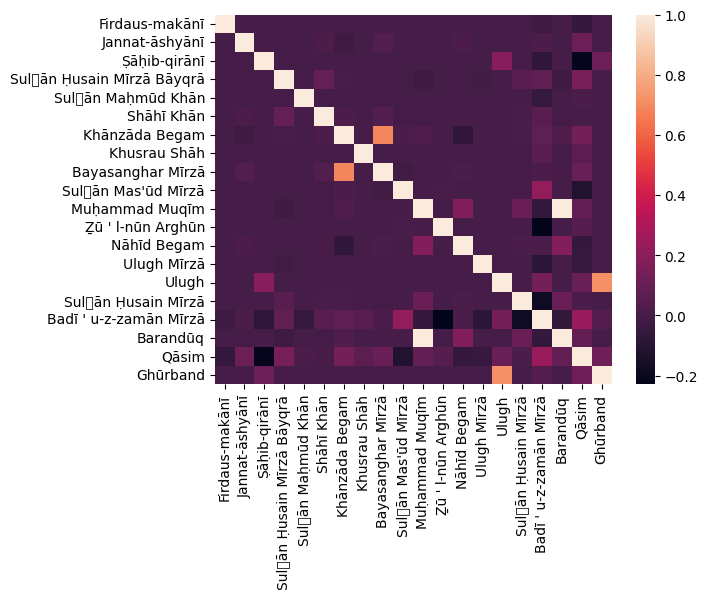

In [14]:
distances = embeddings @ embeddings.transpose()
seaborn.heatmap(distances[:20, :20], xticklabels=names[:20], yticklabels=names[:20])

# Connection Graph
We can also use the co-occurrence matrix to construct a graph of the various people involved, treating the co-occurrence matrix as an *adjacency matrix* – two people have an edge connecting their names if they co-occur at least once.

## Constructing the Graph

In [7]:
# Collapse name1-name2 and name2-name1
for (n1, n2) in [(n1, n2) for n1 in names for n2 in names]:
    if (n1 <= n2): continue
    cooccurrence[(n2, n1)] += cooccurrence[(n1, n2)]
    del cooccurrence[(n1, n2)]

In [8]:
# Construct graph
G = nx.Graph()
G.add_nodes_from(names)
for (n1, n2) in cooccurrence:
    if cooccurrence[(n1, n2)] > 0:
        G.add_edge(n1, n2)

In [9]:
# Remove nodes without edges
for n in names:
    if len(G.edges(n)) == 0:
        G.remove_node(n)

This graph ends up being extremely disconnected – we ignore the outlying smaller graphs, and only consider the largest connected component.

/Users/abhinavmenon/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 61701 (\uf105) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


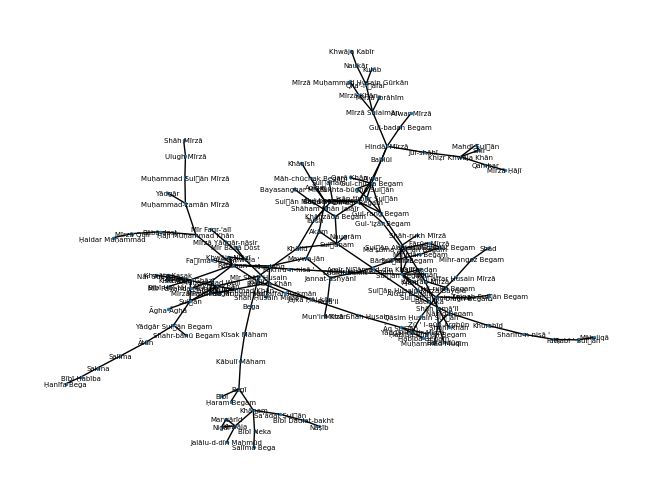

In [10]:
components = [G.subgraph(c).copy() for c in sorted(nx.connected_components(G), key=len, reverse=True)]

component = components[0]
nx.draw(component, nx.spring_layout(component), node_size=2, with_labels=True, font_size=5)
plt.show()

## Centrality
Since the graph appears extremely convoluted and hard to interpret, we consider certain mathematical attributes of the graph that may help us simplify it.

Node centrality computes, intuitively, how "influential" or "important" a certain node is. This concept comes from sociological studies – more information about their calculation and use can be found [on the Wiki page](https://en.wikipedia.org/wiki/Centrality).

We plot the centrality in descending order.

/Users/abhinavmenon/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 61699 (\uf103) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


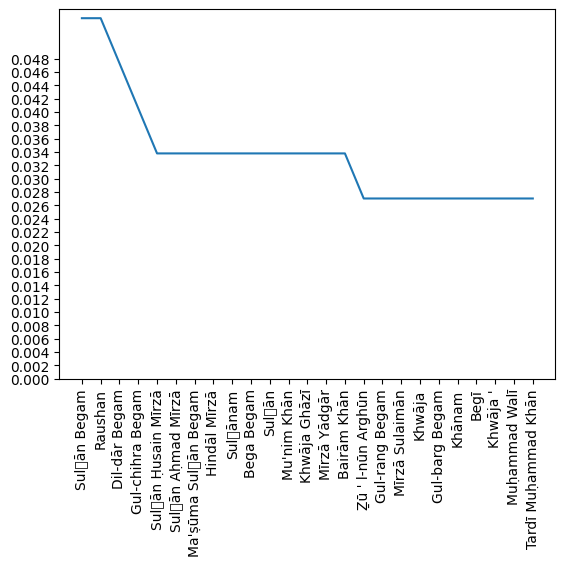

In [12]:
centrality = nx.degree_centrality(component)
centrality = sorted(centrality.items(), key = lambda p : p[1], reverse=True)[:25]
plt.plot(range(len(centrality)), [c for _, c in centrality])
plt.xticks(range(len(centrality)), [n for n, __ in centrality], rotation=90)
plt.yticks([i/500 for i in range(25)])
plt.show()

It is natural then to ask – can we determine centrality from information specific to the person? For example, does centrality correspond to the distance of a person from Humayun?

We plot the distance from Humayun on top of the centrality for each person – this reveals no such correlation.

['Jannat-āshyānī', "Mun'im Khān", 'Khadang', 'Bārbūl Mīrzā']

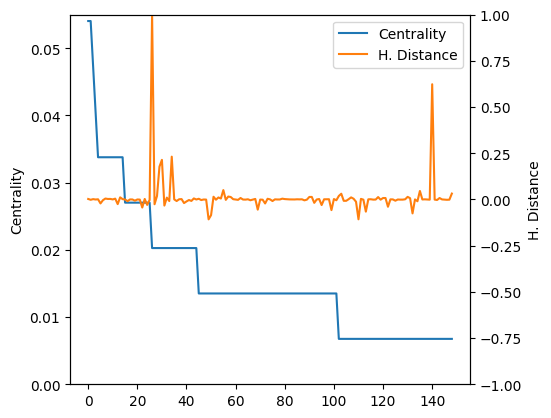

In [81]:
# Is centrality corresponding to distance from Humayun?

fig, ax1 = plt.subplots()
fig.subplots_adjust(right=0.75)
ax2 = ax1.twinx()

p1, = ax1.plot(range(len(centrality)), [c for _, c in centrality], "C0", label="Centrality")
p2, = ax2.plot(range(len(centrality)), [distances[1, names.index(n)] for n, _ in centrality], "C1", label="H. Distance")

ax1.set(ylim=(0, 0.055), ylabel="Centrality")
ax2.set(ylim=(-1, 1), ylabel="H. Distance")

ax1.legend(handles=[p1, p2])

# There are four peaks; who are they?
top4 = np.argsort(distances[1])[::-1][10:][:4] # first 10 are nans
[names[i] for i in top4]

## Subgraphs
As the large graph is unreadable, we consider a smaller graph consisting of the names which have the highest centrality (above 0.02).

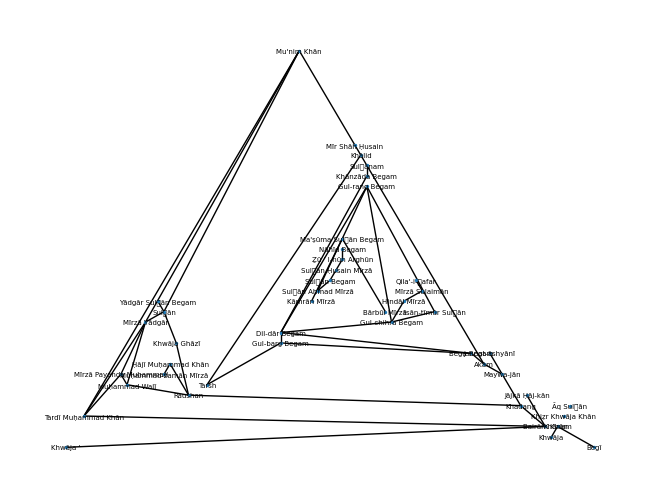

In [30]:
t = 0.02
main_names = nx.Graph.subgraph(component, [name for name, c in centrality if c >= t])
nx.draw(main_names, nx.planar_layout(main_names), node_size=2, with_labels=True, font_size=5)
plt.show()